In [36]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

In [38]:
import xarray as xr

# --- 1. Load Precipitation Data (NetCDF) ---
def load_precipitation(filepath):
    ds = xr.open_dataset(filepath)
    df = ds.to_dataframe().reset_index()
    df = df[df['bnds'] == 0]  # Filter to keep valid bounds
    df.index = pd.to_datetime(df['time'])
    df.index = df.index.normalize()  # Set index to Timestamp (no time component)
    df = df.drop(columns=['time', 'bnds'])
    prec = df['pr'] * 86400  # Convert from m/s to mm/day
    prec[prec < 0] = np.nan  # Handle negative values
    return prec.dropna()

prec = load_precipitation("OBS6_ERA5_reanaly_1_day_pr_2000-2018.nc")

# --- 2. Load Potential Evapotranspiration (NetCDF) ---
def load_evapotranspiration(filepath):
    ds = xr.open_dataset(filepath)
    df = ds.to_dataframe().reset_index()
    df.index = pd.to_datetime(df['time'])
    df.index = df.index.normalize()
    ep = df['evspsblpot'] * 86400  # Convert from mm/s to mm/day
    ep[ep < 0] = np.nan
    return ep.dropna()

EP = load_evapotranspiration("Derived_Makkink_evspsblpot_2000_2018.nc")

# --- 3. Load Discharge Data (CSV) ---
def load_discharge(filepath, basin_area):
    df = pd.read_csv(filepath, delimiter=";", skiprows=37, header=None, encoding='latin1')
    df = df[[0, 2]]  # Keep only date and Q columns
    df.columns = ['Date', 'Q']
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df.set_index('Date', inplace=True)
    df['Q'] = (df['Q'] / basin_area) * 1e3 * 86400  # Convert to mm/day
    df['Q'][df['Q'] < 0] = np.nan
    return df['Q'].dropna()

A = 21497e6  # Basin area in m²
dfQ = load_discharge("6227510_Q_Day.Cmd.txt", A)

# --- 4. Align Time Series (2000-2017) ---
def align_data(prec, EP, Q, start_year=2000, end_date='2017-09-30'):
    # Filter by date range
    prec = prec[(prec.index.year >= start_year) & (prec.index <= pd.to_datetime(end_date))]
    EP = EP[(EP.index.year >= start_year) & (EP.index <= pd.to_datetime(end_date))]
    Q = Q[(Q.index.year >= start_year) & (Q.index <= pd.to_datetime(end_date))]
    # Merge into a single DataFrame
    aligned_data = pd.concat([prec, EP, Q], axis=1, join='inner')
    aligned_data.columns = ['prec', 'EP', 'Q']
    return aligned_data

final_data = align_data(prec, EP, dfQ)
# Drop rows where any column has a NaN value
final_data = final_data.dropna()
print(final_data.head())

prec = final_data['prec']
EP = final_data['EP']
Q = final_data['Q']


                prec        EP         Q
2000-01-01  0.004016  1.168847  0.034243
2000-01-02  0.000000  1.184061  0.034726
2000-01-03  0.020909  1.059634  0.034927
2000-01-04  0.000000  1.175390  0.034525
2000-01-05  0.000000  1.182336  0.035047


C:\Users\margh\AppData\Local\Temp\ipykernel_23144\4200703128.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Q'][df['Q'] < 0] = np.nan


In [ ]:
n = len(prec)
t = np.arange(n)
Si1 = np.zeros(n)
Si_max = 2.5 #?????????????????????????????????????????????????????????????????''
Pe_1 = np.zeros(n)
for t in np.arange(1,n,1):

    Si1[t] = Si1[t-1] + prec.iloc[t]  # Use .iloc to get the scalar value
    if Si1[t] > Si_max:
        Pe_1[t] = Si1[t] - Si_max
    else:
        Pe_1[t] = 0
    Si1[t] = Si1[t] - Pe_1[t]
    deltS = Si1[t] - EP.iloc[t]  # Use .iloc to get the scalar value
    Si1[t] = np.maximum(0, deltS)

Pe_1_mean = Pe_1.mean()


print(Pe_1_mean/prec.mean())


0.590501186388776


In [41]:
print(len(prec.index))
print(len(EP.index))
print(len(Q))
print(len(Si1))
print(len(Pe_1))


6124
6124
6124
6124
6124


In [48]:
data = pd.DataFrame({'P': prec, 'EP': EP, 'Q': Q,  'S': Si1, 'Pe': Pe_1}, index=prec.index)
data.head(15)

,P,EP,Q,S,Pe
2000-01-01,0.004016,1.168847,0.034243,0.000000,0.000000
2000-01-02,0.000000,1.184061,0.034726,0.000000,0.000000
2000-01-03,0.020909,1.059634,0.034927,0.000000,0.000000
2000-01-04,0.000000,1.175390,0.034525,0.000000,0.000000
2000-01-05,0.000000,1.182336,0.035047,0.000000,0.000000
2000-01-06,0.000793,1.199630,0.035128,0.000000,0.000000
2000-01-07,0.000000,1.223502,0.035972,0.000000,0.000000
2000-01-08,0.000000,0.953342,0.036414,0.000000,0.000000
2000-01-09,1.723231,1.049964,0.037338,0.673267,0.000000
2000-01-10,2.129957,0.699373,0.043769,1.800627,0.303224


<Axes: >

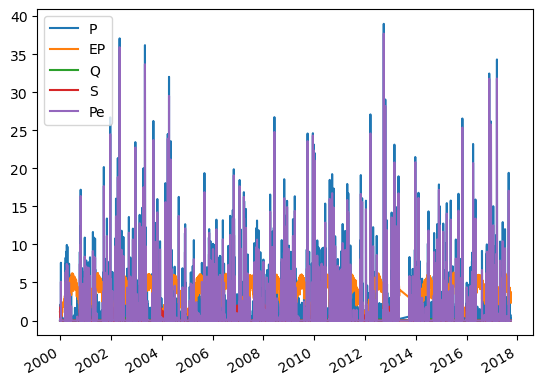

In [49]:
data.plot()

In [44]:
P = data['P'].mean()
Pe = data['Pe'].mean()

print(Pe/prec.mean())

0.590501186388776


In [45]:
#PROBLEM 2
P_mean = data['P'].mean()
EP_mean = data['EP'].mean()
Q_mean = data['Q'].mean()

ET_mean = P_mean - Q_mean #transpiration

#print (P_mean, EP_mean, Q_mean, ET_mean)

data.loc[:,'ET'] = (data['EP']/EP_mean)*ET_mean

data.loc[:,'P-ET'] = data['P'] - data['ET']


for i in range(1, len(data)):
    if data['P-ET'].iloc[:i].cumsum().iloc[-1] > 0:
        data.loc[data.index[i], 'SD'] = 0
    else:
        data.loc[data.index[i], 'SD'] = data['P-ET'].iloc[:i].cumsum().iloc[-1]


SR = data['SD'].min()
        
print(-SR)

267.9207754143298
